In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import semisupervised_vae_lib as ss_vae_lib

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import cifar_data_utils
from cifar_vae_lib import CIFARConditionalVAE
from cifar_classifier_lib import Wide_ResNet
import cifar_semisupervised_lib


In [2]:
seed = 13423
np.random.seed(seed)
_ = torch.manual_seed(seed)


# Load data

In [3]:
train_set_labeled, train_set_unlabeled, test_set = \
    cifar_data_utils.load_semisupervised_cifar_dataset(propn_sample=0.001, 
                                                      propn_labeled = 0.1)

| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified


In [4]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  5
num_train_unlabled:  45
num_test:  10


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

labels_legend_all = unpickle('../cifar100_data/cifar-100-python/meta')
fine_labels_legend = labels_legend_all[b'fine_label_names']

In [6]:
def plot_cifar_image(image, label):
    image_unscaled = image * cifar_data_utils.CIFAR_STD_TENSOR + cifar_data_utils.CIFAR_MEAN_TENSOR

    img = np.dstack((image_unscaled[0, :, :],
                            image_unscaled[1, :, :],
                            image_unscaled[2, :, :]))

    plt.imshow(img)
    plt.title(fine_labels_legend[label])

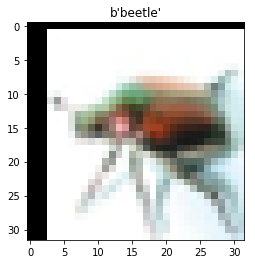

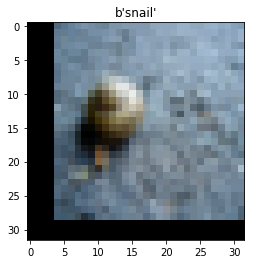

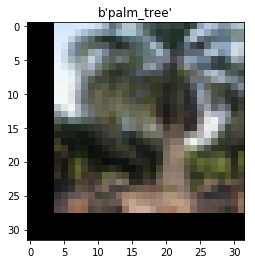

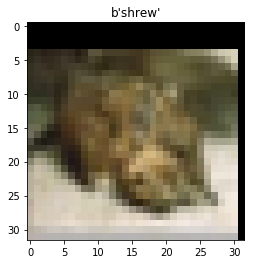

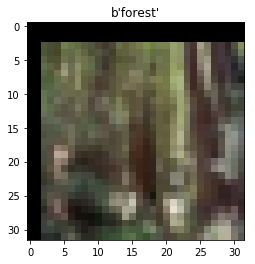

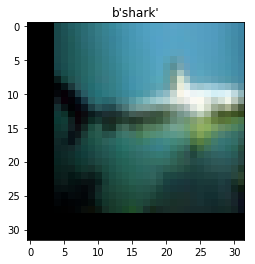

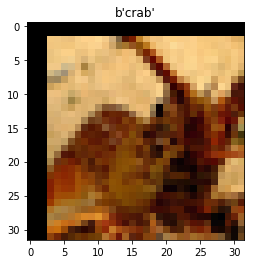

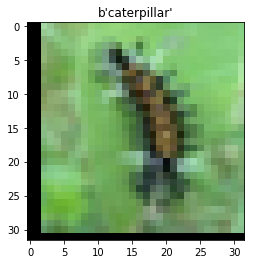

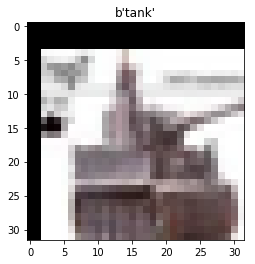

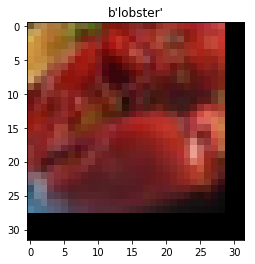

In [7]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(train_set_unlabeled[i]['image'].squeeze(), train_set_unlabeled[i]['label'])

In [8]:
slen = train_set_labeled[0]['image'].shape[-1]

# Get data loaders

In [9]:
batchsize = 5

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=train_set_labeled.num_images,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [10]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [11]:
data_unlabeled['image'].shape

torch.Size([5, 3, 32, 32])

In [12]:
data_labeled['image'].shape

torch.Size([5, 3, 32, 32])

In [13]:
data_test['image'].shape

torch.Size([5, 3, 32, 32])

# Define VAE

In [14]:
image_config = {'slen': 32,
                 'channel_num': 3,
                 'n_classes': 100}

cond_vae_config = {'kernel_num': 5,
                   'z_size': 2}

# classifier_config = {'depth': 10,
#                      'widen_factor': 2,
#                      'dropout_rate': 0.3}

classifier_config = {'depth': 5,
                     'k': 3}

In [15]:
cifar_vae = \
    cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config, cond_vae_config, classifier_config)

## check conditional vae

In [17]:
latent_means, latent_std, latent_samples, image_mean, image_var = \
    cifar_vae.conditional_vae.forward(data_unlabeled['image'], data_unlabeled['label'])

In [18]:
image_mean.shape

torch.Size([5, 3, 32, 32])

In [19]:
latent_means.shape

torch.Size([5, 2])

In [20]:
latent_std.shape

torch.Size([5, 2])

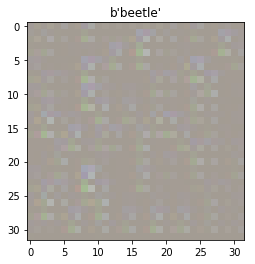

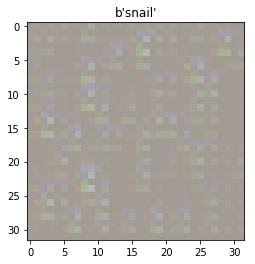

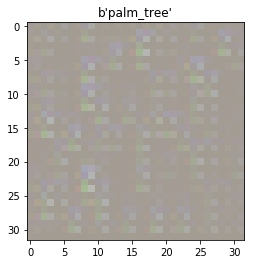

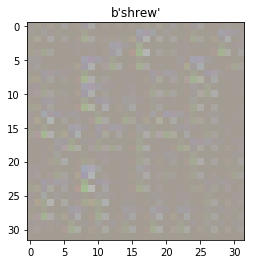

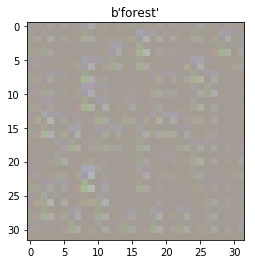

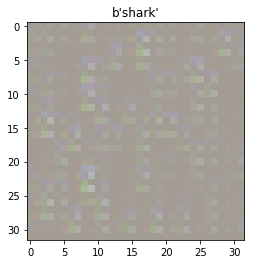

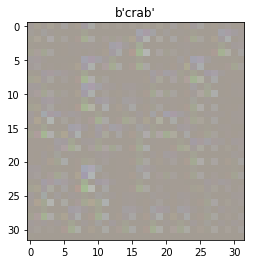

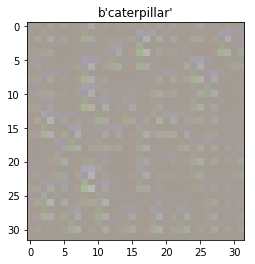

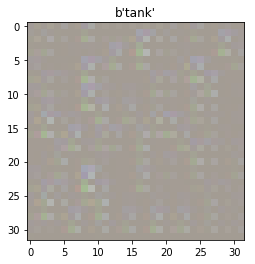

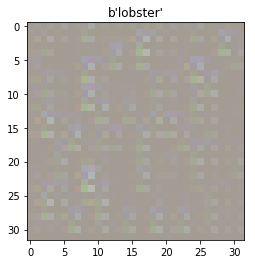

In [21]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(image_mean[0].detach(), train_set_unlabeled[i]['label'])

### check classifier

In [22]:
log_q = cifar_vae.classifier.forward(data_unlabeled['image'])

In [23]:
assert np.all(log_q.detach().numpy() < 0)

In [24]:
print(log_q.shape)

torch.Size([5, 100])


In [25]:
torch.sum(torch.exp(log_q), dim = 1)

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

### check loss goes through

In [26]:
cond_loss = cifar_vae.get_conditional_loss(data_unlabeled['image'], data_unlabeled['label'])

In [27]:
assert len(cond_loss) == len(data_unlabeled['label'])

In [28]:
cond_loss

tensor([-12890.9082, -12890.9092, -12890.9082, -12890.9092, -12890.9072])

In [29]:
cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 1000, 1000,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

(tensor(-2.6080e+07), tensor(-64594.0938))

# Check gradient works 

In [30]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [31]:
vae_params0 = get_vae_params(cifar_vae)

In [32]:
assert np.any(np.isnan(vae_params0)) == False

In [33]:
optimizer = optim.Adam(cifar_vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [34]:
loss, map_loss1 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

tensor(-64588.3047)


In [35]:
loss.backward()
optimizer.step()

In [36]:
vae_params1 = get_vae_params(cifar_vae)

In [37]:
assert np.any(np.isnan(vae_params1)) == False

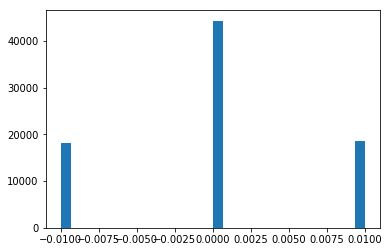

In [38]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [39]:
loss, map_loss2 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


In [40]:
map_loss2

tensor(-66221.1797)

In [41]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [42]:
from torch.utils.data.sampler import Sampler

In [43]:
train_loader_unlabeled = None

In [44]:
ss_vae_lib.train_semisupervised_model(cifar_vae, train_loader_unlabeled, 
                                        train_loader_labeled, 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test', 
                                        use_true_labels = False)

  * init train recon loss: -11105.75977;
  * init test recon loss: -5431.133301;
  * init labeled class accuracy:    0;
  * init train class accuracy: -1;
  * init test class accuracy:    0;
[1] unlabeled_loss: -13753.25293  	[0.0 seconds]
[2] unlabeled_loss: -13394.85645  	[0.0 seconds]
  * train recon loss: -11061.47363;
  * test recon loss: -5433.759766;
  * labeled class accuracy:    0;
  * train class accuracy: -1;
  * test class accuracy:    0;
[3] unlabeled_loss: -14079.89062  	[0.0 seconds]
[4] unlabeled_loss: -14043.71582  	[0.0 seconds]
  * train recon loss: -11036.6582;
  * test recon loss: -5431.653809;
  * labeled class accuracy:    0;
  * train class accuracy: -1;
  * test class accuracy:    0;
[5] unlabeled_loss: -13934.11426  	[0.0 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [45]:
torch.exp(cifar_vae.classifier(data_unlabeled['image']).detach())

tensor(1.00000e-02 *
       [[ 0.8790,  0.8534,  0.7404,  0.8282,  0.2835,  0.8305,  0.4290,
          0.9218,  1.1362,  0.5214,  0.9158,  0.8821,  0.9169,  0.5446,
          2.3668,  0.5374,  0.7701,  0.5011,  1.4693,  1.0918,  1.4429,
          2.4581,  1.6788,  0.3029,  1.1255,  1.6215,  1.6976,  0.9316,
          1.5565,  0.7594,  0.9228,  0.3065,  0.5682,  0.3557,  0.3044,
          1.8676,  1.2957,  1.7446,  0.6061,  2.1370,  1.8905,  0.7652,
          0.6645,  0.6023,  1.3136,  1.3336,  1.1535,  1.6495,  0.5035,
          0.7199,  1.4173,  0.4631,  0.9338,  1.0202,  1.8633,  1.1150,
          1.1484,  0.9974,  0.8787,  0.4284,  0.3558,  0.4450,  1.3079,
          0.4463,  1.4945,  1.5476,  0.3522,  0.6204,  1.4610,  0.5721,
          0.3886,  1.3130,  0.7605,  1.1867,  0.3784,  0.3499,  0.8162,
          2.1176,  0.8357,  1.6157,  1.9825,  0.7440,  0.5041,  0.8550,
          1.1707,  0.7373,  0.4884,  1.4900,  0.2917,  1.5722,  1.2133,
          0.4292,  0.5931,  0.6577,  1.3743

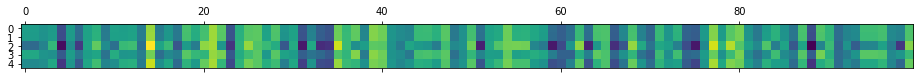

In [46]:
plt.matshow(cifar_vae.classifier(data_unlabeled['image']).detach())

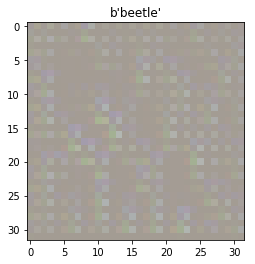

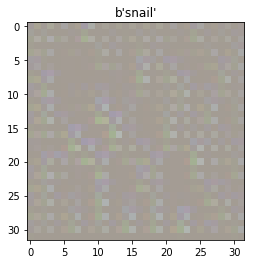

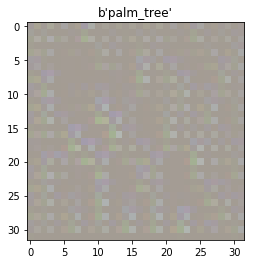

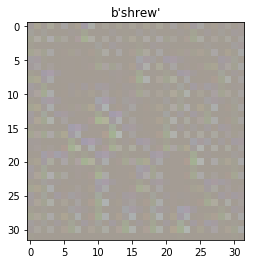

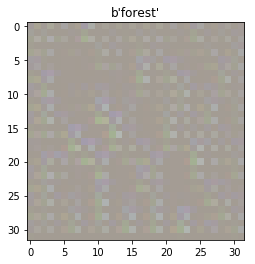

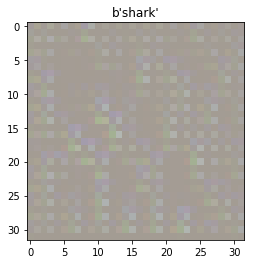

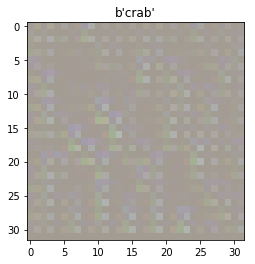

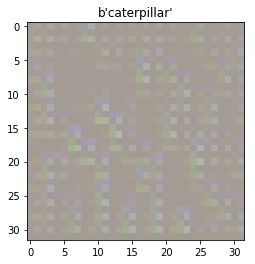

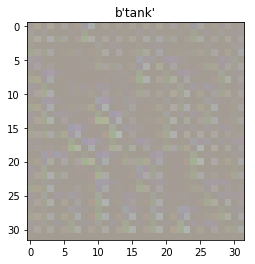

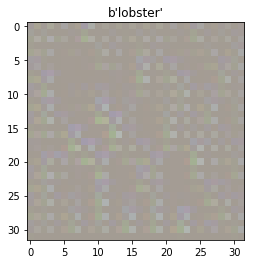

In [47]:
latent_means, latent_std, latent_samples, image_mean, image_var = \
    cifar_vae.conditional_vae.forward(data_unlabeled['image'], data_unlabeled['label'])
    
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(image_mean[0].detach(), train_set_unlabeled[i]['label'])

In [48]:
# check reloading

In [49]:
reload_cifar_vae = \
    cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config, cond_vae_config, classifier_config)

# mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

In [50]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'
classifier_file = './test_classifier_final'

reload_cifar_vae.conditional_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_cifar_vae.conditional_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

reload_cifar_vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


In [51]:
reload_cifar_vae.eval_vae(train_loader_unlabeled, train_loader_labeled)

tensor(-11078.8047)

In [52]:
import torch
from torch.utils.data import DataLoader, Dataset


In [51]:
class DummyDataset(Dataset):
    """
    Dataset of numbers in [a,b] inclusive
    """

    def __init__(self, a=0, b=100):
        super(DummyDataset, self).__init__()
        self.a = a
        self.b = b

    def __len__(self):
        return self.b - self.a + 1

    def __getitem__(self, index):
        return index, "label_{}".format(index)

dataloaders1 = DataLoader(DummyDataset(0, 9), batch_size=2, shuffle=True)
dataloaders2 = DataLoader(DummyDataset(0, 4), batch_size=2, shuffle=True)

for i, data in enumerate(zip(dataloaders1, dataloaders2)):
    print(data)


([tensor([ 4,  3]), ('label_4', 'label_3')], [tensor([ 1,  4]), ('label_1', 'label_4')])
([tensor([ 2,  5]), ('label_2', 'label_5')], [tensor([ 3,  2]), ('label_3', 'label_2')])
([tensor([ 8,  1]), ('label_8', 'label_1')], [tensor([ 0]), ('label_0',)])
